In [98]:
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import community.community_louvain as louvain
import numpy as np
from scipy import sparse
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import pandas as pd
from sklearn

from tqdm import tqdm

In [47]:
dataset = pd.read_csv("./preprocessed_data_csv.csv")
dataset.columns

Index(['cancer_type', 'title', 'username', 'date', 'content', 'comments'], dtype='object')

In [141]:
userlist = dataset['username'].unique()
userlist = pd.Series(userlist)


In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
lemmatizer = WordNetLemmatizer()

In [71]:
# Load stopwords
stop_words = set(stopwords.words('english'))

In [69]:
# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special symbols and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Lemmatize tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stopwords
    filtered_tokens = [word for word in lemmatized_tokens if word not in stop_words]
    # Join tokens back to form text
    processed_text = ' '.join(filtered_tokens)
    return processed_text

In [131]:
user_activity = (dataset
                 .groupby('username')['content']
                 .aggregate(lambda x: "|".join(map(str, x)))
                .to_frame().reset_index())
user_activity = user_activity.sample(500).reset_index(drop=True)
preprocessed = user_activity['content'].map(preprocess_text)


In [191]:
preprocessed

0      himy name kevin wright researcher university m...
1      experience others seems like facial neck nerve...
2      year old male smoked year recently quit kidney...
3      hi name tracey im kent englandmy story long ex...
4      hi brief history reference treatment except ch...
                             ...                        
495    exploring option nd opinion treatment outside ...
496    adult son wa recently diagnosed acute tcell ly...
497    hi bladder hemangioma arteriorvenus malformati...
498    month ago started running low grade fever nigh...
499    wa rushed er back september chest pain abnorma...
Name: content, Length: 500, dtype: object

In [6]:
# Load JSON data
with open('preprocessed_data.json', 'r') as f:
    data = json.load(f)

In [7]:
# Preprocess data
documents = []
for cancer_type, posts in tqdm(data.items()):
    for post_data in posts:
        try:
            processed_content = preprocess_text(post_data['content'])
            documents.append(processed_content)
        except KeyError as e:
            print(f"KeyError occurred for post: {post_data}")
            continue

100%|██████████| 28/28 [00:03<00:00,  7.95it/s]


In [132]:
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed)

In [133]:
# Calculate cosine similarity matrix
# cosine_sim_matrix = sparse.csr_matrix(np.dot(tfidf_matrix, tfidf_matrix.T).toarray())


similarities = cosine_similarity(tfidf_matrix, tfidf_matrix) 
similarities.shape

(500, 500)

In [193]:
from sklearn.cluster import KMeans

c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


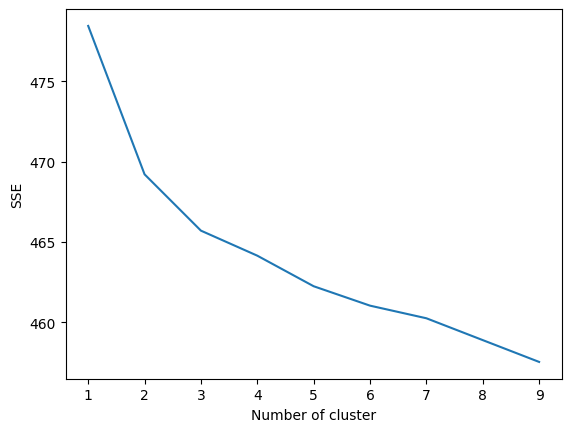

In [194]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tfidf_matrix)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [196]:
n = 3
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(tfidf_matrix)

c:\Users\vedan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(500,)

In [197]:
preprocessed

0      himy name kevin wright researcher university m...
1      experience others seems like facial neck nerve...
2      year old male smoked year recently quit kidney...
3      hi name tracey im kent englandmy story long ex...
4      hi brief history reference treatment except ch...
                             ...                        
495    exploring option nd opinion treatment outside ...
496    adult son wa recently diagnosed acute tcell ly...
497    hi bladder hemangioma arteriorvenus malformati...
498    month ago started running low grade fever nigh...
499    wa rushed er back september chest pain abnorma...
Name: content, Length: 500, dtype: object

In [134]:
# Constructing the Graph
G = nx.Graph()

thresh = 0.2

for user in user_activity['username'].unique():
    combined_texts = user_activity[user_activity['username'] == user]
    content = combined_texts['content'].values[0]
    idx = combined_texts.index[0]

    similar_users = np.where((similarities[idx] >= thresh) & (similarities[idx] != 1))
    for item in similar_users[0]:
        A = user
        B = user_activity['username'][item]
        if A != B:
            G.add_edge(user, user_activity['username'][item])


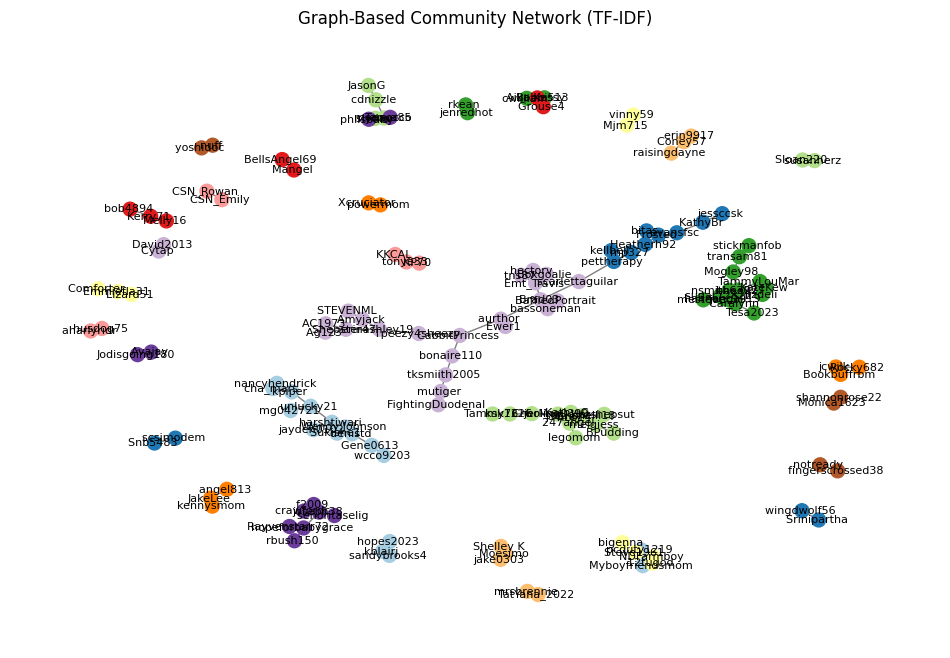

In [135]:
partition = louvain.best_partition(G)
user_activity['community'] = user_activity['username'].map(partition)
pos = nx.spring_layout(G)
plt.figure(figsize=(12,8))

colors = [partition[node] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.Paired, node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.5)
labels = {node: user_activity.loc[user_activity['username'] == node, 'username'].values[0] for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title('Graph-Based Community Network (TF-IDF)')
plt.axis('off')
plt.show()

In [146]:
# inject users in comments
comments = dataset[["username", 'comments']]

In [173]:
def assign_user(items):
    username, comments = items
    
    sampled = userlist.sample(len(comments[:10]), replace=True)
    edges = [(sample, username) for sample, comment in zip(sampled, comments)]
    
    return edges

In [174]:
edges = comments[["username", 'comments']].apply(assign_user, axis=1).to_list()

In [185]:
nodes = []

for item in edges[:20]:
    for A, B in item:
        if A not in nodes:
            nodes.append(A)

        if B not in nodes:
            nodes.append(B)

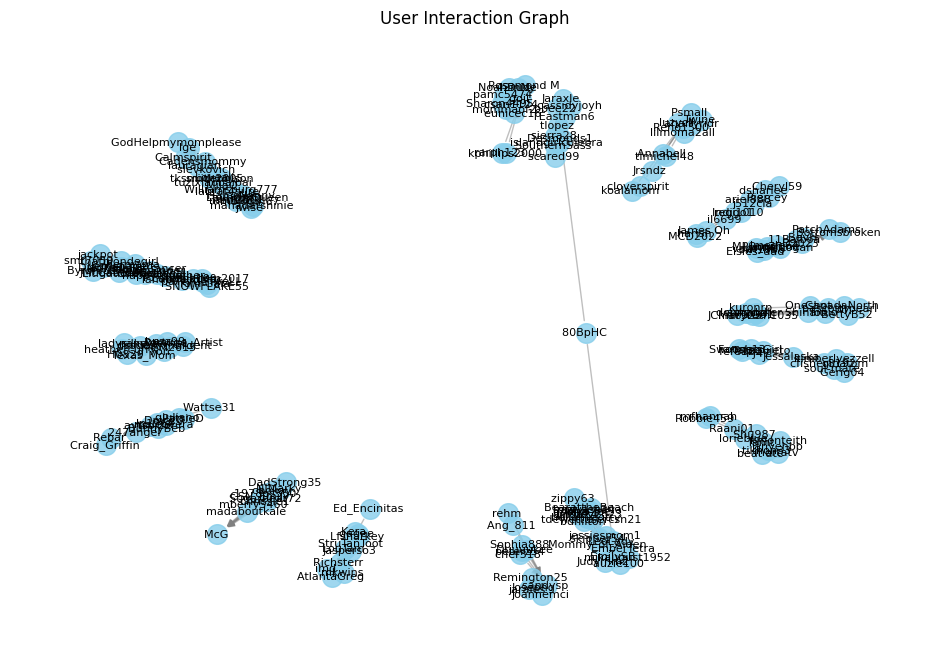

In [190]:
G = nx.DiGraph()

G.add_nodes_from(nodes)

for _set in edges[:20]:
    for A, B in _set:
        G.add_edge(A, B)

pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))

nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('User Interaction Graph')
plt.axis('off')
plt.show()

In [38]:
# Constructing the Graph
G = nx.Graph()

# Adding nodes for posts and comments
for i, post_data in enumerate(data.values()):
    
    for j, post in enumerate(tqdm(post_data)):
        post_index = f"post_{i}_{j}"
        G.add_node(post_index, type='post')
        
        for comment in post['comments']:
            G.add_node(f"comment_{i}_{j}_{post['comments'].index(comment)}", type='comment')
            G.add_edge(post_index, f"comment_{i}_{j}_{post['comments'].index(comment)}")
        
        for k, other_post_data in enumerate(data.values()):
            if i != k:
                for other_post in other_post_data:
                    other_post_index = f"post_{k}_{other_post_data.index(other_post)}"
                    similarity = similarities[i,k]
                    G.add_node(other_post_index, type='post')
                    G.add_edge(post_index, other_post_index, weight=similarity)


 32%|███▏      | 46/146 [00:00<00:01, 51.64it/s]


KeyboardInterrupt: 

In [ ]:
# Community Detection
communities = community.greedy_modularity_communities(G)

# Subsample the graph for visualization
subgraph_nodes = [node for community in communities for node in community]
subgraph = G.subgraph(subgraph_nodes)

# Use a faster layout algorithm
pos = nx.spring_layout(subgraph, k=0.15, iterations=20)

# Visualize the subgraph
plt.figure(figsize=(12, 8))

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, nodelist=subgraph.nodes(), node_size=50, node_color='skyblue', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(subgraph, pos, width=0.5, alpha=0.5)

plt.title('Community Detection (Simplified and Less Cluttered Graph)')
plt.axis('off')  # Turn off axis
plt.show()

In [38]:
# Print communities
for i, community in enumerate(communities):
    print(f"Community {i+1}:")
    for node in community:
        print(node)

Streaming output truncated to the last 5000 lines.
comment_6_20_0
comment_6_20_1
post_6_20
Community 2035:
post_6_22
comment_6_22_1
comment_6_22_0
Community 2036:
comment_6_26_0
post_6_26
comment_6_26_1
Community 2037:
post_6_35
comment_6_35_0
comment_6_35_1
Community 2038:
post_6_36
comment_6_36_0
comment_6_36_1
Community 2039:
post_6_37
comment_6_37_0
comment_6_37_1
Community 2040:
post_6_40
comment_6_40_1
comment_6_40_0
Community 2041:
post_6_44
comment_6_44_1
comment_6_44_0
Community 2042:
comment_6_49_1
comment_6_49_0
post_6_49
Community 2043:
comment_6_52_1
post_6_52
comment_6_52_0
Community 2044:
comment_6_53_1
post_6_53
comment_6_53_0
Community 2045:
comment_6_57_1
comment_6_57_0
post_6_57
Community 2046:
comment_6_61_0
comment_6_61_1
post_6_61
Community 2047:
comment_6_63_0
comment_6_63_1
post_6_63
Community 2048:
comment_6_68_1
post_6_68
comment_6_68_0
Community 2049:
comment_6_88_0
comment_6_88_1
post_6_88
Community 2050:
comment_6_103_0
comment_6_103_1
post_6_103
Community 

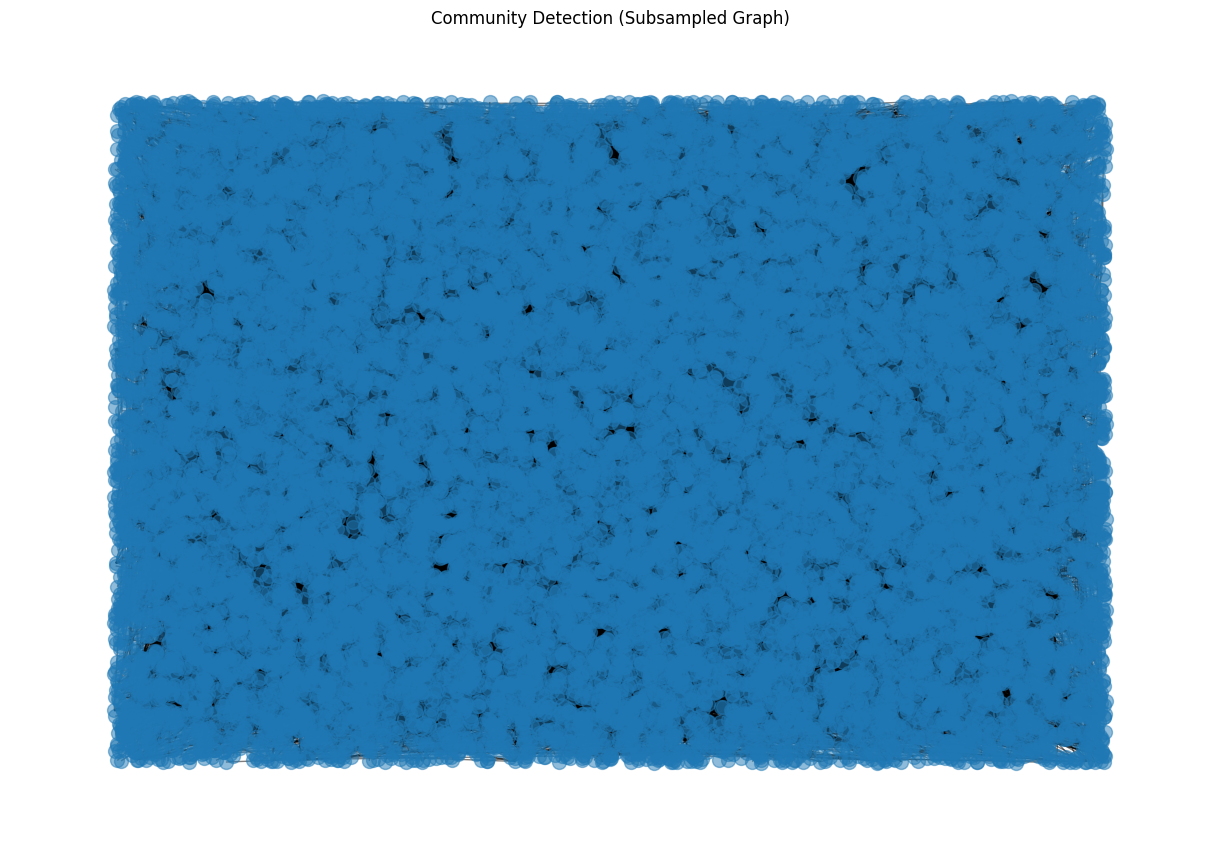

In [43]:
# Subsample the graph for visualization
subgraph_nodes = [node for community in communities for node in community]
subgraph = G.subgraph(subgraph_nodes)

# Use a faster layout algorithm
pos = nx.random_layout(subgraph)

# Visualize the subgraph
plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos, node_size=100, alpha=0.5, with_labels=False)
plt.title('Community Detection (Subsampled Graph)')
plt.show()